<a href="https://colab.research.google.com/github/Tessellate-Imaging/Monk_Object_Detection/blob/master/example_notebooks/3_mxrcnn/Example%20-%20weapon%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

 - Run these commands
     
     - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git
     
     - cd Monk_Object_Detection/3_mxrcnn/installation
     
 - Select the right requirements file and run
 
     - cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

In [ ]:
! git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install


# For Local systems and cloud select the right CUDA version
#! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

# Download Dataset

- credits: https://sci2s.ugr.es/weapons-detection

- Install kaggle client using: https://github.com/Kaggle/kaggle-api
    - CMD: `pip install -U kaggle`
    

In [2]:
! kaggle datasets download -d abhishek4273/gun-detection-dataset -q

In [3]:
! unzip -qq gun-detection-dataset.zip

# Current dataset annotation - Monk Format

## Dataset Directory Structure

    weapons (root)
          |
          |-----------Images (img_dir)
          |              |
          |              |------------------img1.jpg
          |              |------------------img2.jpg
          |              |------------------.........(and so on)
          |
          |
          |-----------train_labels.csv (anno_file)
          
          
## Annotation file format

           | Id         | Labels                                 |
           | img1.jpg   | x1 y1 x2 y2 label1 x1 y1 x2 y2 label2  |
           
- Labels:  xmin ymin xmax ymax label
- xmin, ymin - top left corner of bounding box
- xmax, ymax - bottom right corner of bounding box

# Desired annotation - COCO Format

## Dataset Directory Structure

    ./ (root_dir)
          |
          |------weapons (coco_dir) 
          |         |
          |         |---Images (img_dir)
          |         |----|
          |              |-------------------img1.jpg
          |              |-------------------img2.jpg
          |              |-------------------.........(and so on)
          |
          |
          |         |---annotations (anno_dir)
          |         |----|
          |              |--------------------instances_Images.json 
          |              |--------------------classes.txt
          
          
 - instances_Train.json -> In proper COCO format
 - classes.txt          -> A list of classes in alphabetical order

# Annotation Conversion

In [1]:
import os
import numpy as np 
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

In [2]:
# Provide details on directory in Monk Format

In [3]:
root = "weapons";
img_dir = "Images/";
anno_file = "train_labels.csv";

In [4]:
# Need not change anything below

In [5]:
dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

In [6]:
if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)
    
input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

In [7]:
output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

In [8]:
if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

In [9]:
df = pd.read_csv(input_annotations_path);
columns = df.columns

In [10]:
delimiter = " ";

In [11]:
list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
    
for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();

100%|██████████| 1/1 [00:00<00:00, 5940.94it/s]


In [12]:
coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);
    

    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

100%|██████████| 3000/3000 [00:15<00:00, 192.27it/s]


# Training

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from train_base import *

In [3]:
# Dataset params

In [4]:
root_dir = "./";
coco_dir = "weapons";
img_dir = "Images"; 

In [5]:
set_dataset_params(root_dir=root_dir, 
                   coco_dir=coco_dir, imageset=img_dir);

In [6]:
# Model Type

In [6]:
set_model_params(model_name="vgg16");

In [7]:
# Hyper Params

In [8]:
set_hyper_params(gpus="0", lr=0.001, lr_decay_epoch="1", epochs=2, batch_size=1);

In [9]:
set_output_params(log_interval=100, save_prefix="model_vgg16");

In [10]:
# Preprocessing params

In [11]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [12]:
# Initialize params

In [13]:
initialize_rpn_params();

In [14]:
initialize_rcnn_params();

In [15]:
# Remove caches if any

In [16]:
if os.path.isdir("./cache/"):
    os.system("rm -r ./cache/")

In [17]:
# Invoke Dataloader

In [18]:
roidb = set_dataset();

INFO:root:computing cache ./cache/coco_Images_roidb.pkl
INFO:root:saving cache ./cache/coco_Images_roidb.pkl
INFO:root:coco_Images num_images 3000
INFO:root:filter roidb: 3000 -> 3000
INFO:root:coco_Images append flipped images to roidb


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [19]:
#Network

In [20]:
sym = set_network();

In [21]:
# Train

In [22]:
train(sym, roidb);

INFO:root:max input shape
{'bbox_target': (1, 36, 62, 62),
 'bbox_weight': (1, 36, 62, 62),
 'data': (1, 3, 1000, 1000),
 'gt_boxes': (1, 100, 5),
 'im_info': (1, 3),
 'label': (1, 1, 558, 62)}
INFO:root:max output shape
{'bbox_loss_reshape_output': (1, 128, 8),
 'blockgrad0_output': (1, 128),
 'cls_prob_reshape_output': (1, 128, 2),
 'rpn_bbox_loss_output': (1, 36, 62, 62),
 'rpn_cls_prob_output': (1, 2, 558, 62)}
INFO:root:locking params
['conv1_1_weight',
 'conv1_1_bias',
 'conv1_2_weight',
 'conv1_2_bias',
 'conv2_1_weight',
 'conv2_1_bias',
 'conv2_2_weight',
 'conv2_2_bias',
 'conv3_1_weight',
 'conv3_1_bias',
 'conv3_2_weight',
 'conv3_2_bias',
 'conv3_3_weight',
 'conv3_3_bias',
 'conv4_1_weight',
 'conv4_1_bias',
 'conv4_2_weight',
 'conv4_2_bias',
 'conv4_3_weight',
 'conv4_3_bias']
INFO:root:lr 0.001000 lr_epoch_diff [1] lr_iters [6000]
INFO:root:Epoch[0] Batch [0-100]	Speed: 5.64 samples/sec	RPNAcc=0.964689	RPNLogLoss=0.169774	RPNL1Loss=1.009820	RCNNAcc=0.880879	RCNNLogLoss

INFO:root:Epoch[0] Batch [0-4400]	Speed: 5.62 samples/sec	RPNAcc=0.976654	RPNLogLoss=0.075244	RPNL1Loss=0.425111	RCNNAcc=0.931379	RCNNLogLoss=0.168348	RCNNL1Loss=1.397141
INFO:root:Epoch[0] Batch [0-4500]	Speed: 5.39 samples/sec	RPNAcc=0.976774	RPNLogLoss=0.074702	RPNL1Loss=0.422499	RCNNAcc=0.931791	RCNNLogLoss=0.167313	RCNNL1Loss=1.388216
INFO:root:Epoch[0] Batch [0-4600]	Speed: 5.41 samples/sec	RPNAcc=0.976892	RPNLogLoss=0.074328	RPNL1Loss=0.420482	RCNNAcc=0.932102	RCNNLogLoss=0.166619	RCNNL1Loss=1.383030
INFO:root:Epoch[0] Batch [0-4700]	Speed: 5.57 samples/sec	RPNAcc=0.976935	RPNLogLoss=0.074072	RPNL1Loss=0.418214	RCNNAcc=0.932378	RCNNLogLoss=0.165897	RCNNL1Loss=1.376758
INFO:root:Epoch[0] Batch [0-4800]	Speed: 5.45 samples/sec	RPNAcc=0.977000	RPNLogLoss=0.073857	RPNL1Loss=0.416608	RCNNAcc=0.932678	RCNNLogLoss=0.165201	RCNNL1Loss=1.369026
INFO:root:Epoch[0] Batch [0-4900]	Speed: 5.54 samples/sec	RPNAcc=0.977135	RPNLogLoss=0.073369	RPNL1Loss=0.414387	RCNNAcc=0.932986	RCNNLogLoss=0.1

INFO:root:Epoch[1] Batch [0-3100]	Speed: 5.56 samples/sec	RPNAcc=0.986259	RPNLogLoss=0.039005	RPNL1Loss=0.221059	RCNNAcc=0.960887	RCNNLogLoss=0.096972	RCNNL1Loss=0.812684
INFO:root:Epoch[1] Batch [0-3200]	Speed: 5.58 samples/sec	RPNAcc=0.986153	RPNLogLoss=0.039238	RPNL1Loss=0.220953	RCNNAcc=0.960916	RCNNLogLoss=0.096846	RCNNL1Loss=0.812110
INFO:root:Epoch[1] Batch [0-3300]	Speed: 5.62 samples/sec	RPNAcc=0.986197	RPNLogLoss=0.039153	RPNL1Loss=0.220631	RCNNAcc=0.960900	RCNNLogLoss=0.096691	RCNNL1Loss=0.808373
INFO:root:Epoch[1] Batch [0-3400]	Speed: 5.65 samples/sec	RPNAcc=0.986200	RPNLogLoss=0.039095	RPNL1Loss=0.220819	RCNNAcc=0.960983	RCNNLogLoss=0.096452	RCNNL1Loss=0.808194
INFO:root:Epoch[1] Batch [0-3500]	Speed: 5.66 samples/sec	RPNAcc=0.986195	RPNLogLoss=0.038982	RPNL1Loss=0.220767	RCNNAcc=0.961074	RCNNLogLoss=0.096240	RCNNL1Loss=0.806590
INFO:root:Epoch[1] Batch [0-3600]	Speed: 5.62 samples/sec	RPNAcc=0.986281	RPNLogLoss=0.038724	RPNL1Loss=0.220721	RCNNAcc=0.961200	RCNNLogLoss=0.0

# Running Inference

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from infer_base import *

In [3]:
class_file = set_class_list("./weapons/annotations/classes.txt");

In [4]:
#Model - Select the model as per number of iterations it has been trained for

In [5]:
set_model_params(model_name="vgg16", model_path="trained_model/model_vgg16-0002.params");

In [6]:
#Hyper Params

In [7]:
set_hyper_params(gpus="0", batch_size=1);

In [8]:
# Preprocessing

In [9]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [10]:
#Initalization

In [11]:
initialize_rpn_params();

In [12]:
initialize_rcnn_params();

In [13]:
#Network

In [14]:
sym = set_network();
mod = load_model(sym);

In [15]:
#Load Image and infer

gun
 0.9871412515640259 [779.4582791760442, 338.18130235549467, 1036.140825940368, 552.9240792563883]
['gun\n', 0.9871412515640259, [779.4582791760442, 338.18130235549467, 1036.140825940368, 552.9240792563883]]


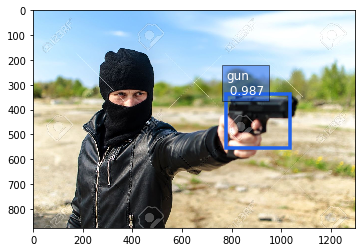

In [16]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img1.jpg", mod);

gun
 0.9824304580688477 [850.7931176589856, 389.7144098532751, 1093.2458640412299, 816.5758142441774]
['gun\n', 0.9824304580688477, [850.7931176589856, 389.7144098532751, 1093.2458640412299, 816.5758142441774]]


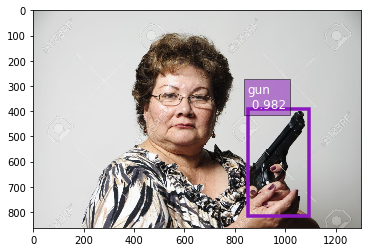

In [17]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img2.jpg", mod);

gun
 0.9905449151992798 [132.21067471554665, 69.00740405890376, 195.4864407958203, 127.03255562680262]
['gun\n', 0.9905449151992798, [132.21067471554665, 69.00740405890376, 195.4864407958203, 127.03255562680262]]


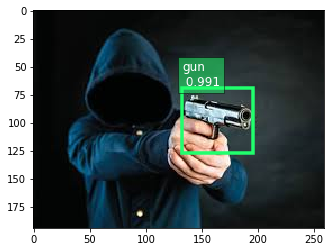

In [18]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img3.jpg", mod);

gun
 0.9278362989425659 [482.52946828600403, 266.5300854515875, 597.0585919617838, 367.16081562452314]
['gun\n', 0.9278362989425659, [482.52946828600403, 266.5300854515875, 597.0585919617838, 367.16081562452314]]


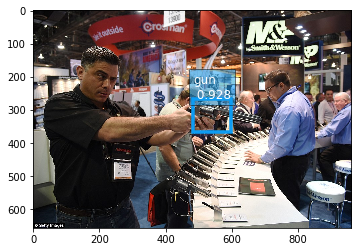

In [19]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img4.jpg", mod);

gun
 0.8518520593643188 [439.9178513055754, 292.289710219374, 558.5641766918238, 386.9297880976927]
['gun\n', 0.8518520593643188, [439.9178513055754, 292.289710219374, 558.5641766918238, 386.9297880976927]]


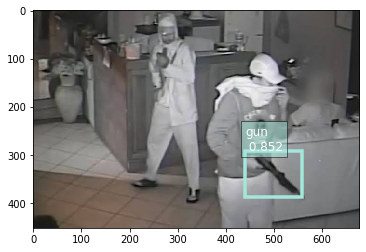

In [20]:
set_output_params(vis_thresh=0.7, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img7.jpeg", mod);

gun
 0.3721257746219635 [244.06872657906965, 81.86917514551497, 295.0226582150013, 143.51843535458443]
['gun\n', 0.3721257746219635, [244.06872657906965, 81.86917514551497, 295.0226582150013, 143.51843535458443]]


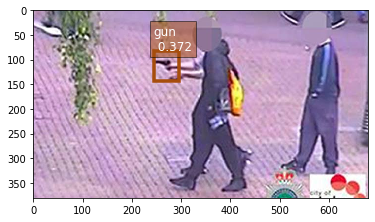

In [21]:
set_output_params(vis_thresh=0.3, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img6.jpeg", mod);

gun
 0.9773700833320618 [299.0503253595365, 140.5074980945873, 376.1354252629678, 242.43304633496493]
['gun\n', 0.9773700833320618, [299.0503253595365, 140.5074980945873, 376.1354252629678, 242.43304633496493]]


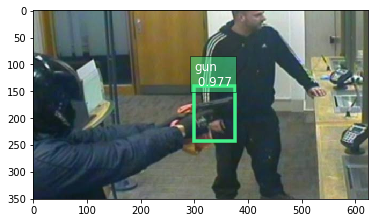

In [22]:
set_output_params(vis_thresh=0.7, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img8.jpeg", mod);

gun
 0.9353173971176147 [371.52340893833696, 71.37336674451618, 484.07012344078623, 144.07764443525562]
['gun\n', 0.9353173971176147, [371.52340893833696, 71.37336674451618, 484.07012344078623, 144.07764443525562]]


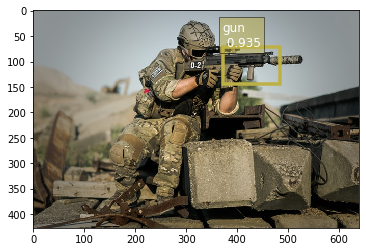

In [23]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img9.jpg", mod);

gun
 0.8997571468353271 [357.59834553731736, 90.18419954881838, 427.35271293923756, 134.89773502280553]
gun
 0.589422345161438 [147.99409159253233, 110.17811196501718, 274.14999790876107, 176.82647391410615]
['gun\n', 0.8997571468353271, [357.59834553731736, 90.18419954881838, 427.35271293923756, 134.89773502280553]]


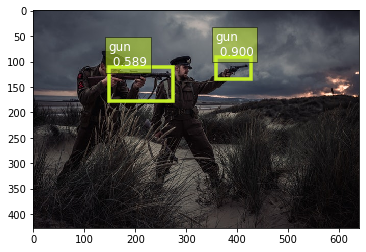

In [24]:
set_output_params(vis_thresh=0.4, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img10.jpg", mod);

gun
 0.9588940143585205 [215.32513450553836, 151.39748763874488, 434.58521341748553, 264.2947230967975]
['gun\n', 0.9588940143585205, [215.32513450553836, 151.39748763874488, 434.58521341748553, 264.2947230967975]]


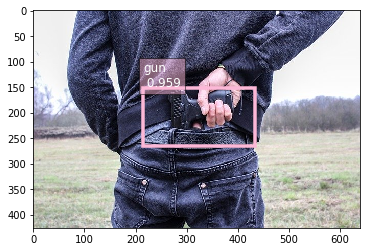

In [25]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img11.jpg", mod);

gun
 0.9461064338684082 [166.50568956001823, 113.41656394343983, 244.86629585589708, 178.75103110152062]
gun
 0.8605337142944336 [46.96892708760816, 92.49699250104509, 95.00524578802899, 145.4168111676179]
gun
 0.8116645216941833 [285.00684708473204, 170.40260839866122, 377.00236125097575, 222.41042931105767]
gun
 0.7817913889884949 [505.93279556465137, 166.55593726227525, 633.415093449133, 266.8657425082163]
gun
 0.7718876600265503 [524.3181674201828, 170.72818061133674, 575.5298579417134, 214.3662930639161]
['gun\n', 0.9461064338684082, [166.50568956001823, 113.41656394343983, 244.86629585589708, 178.75103110152062]]


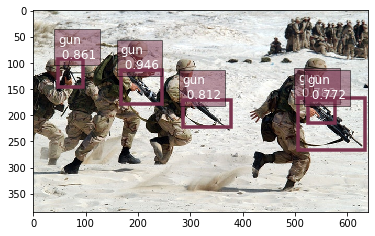

In [26]:
set_output_params(vis_thresh=0.7, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img12.jpg", mod);

gun
 0.9742936491966248 [224.31759910154406, 343.6409053914584, 365.64580601376, 404.3456191302335]
gun
 0.806024968624115 [254.36813682217732, 338.76068491702745, 292.0229410009464, 393.4688097882511]
['gun\n', 0.9742936491966248, [224.31759910154406, 343.6409053914584, 365.64580601376, 404.3456191302335]]


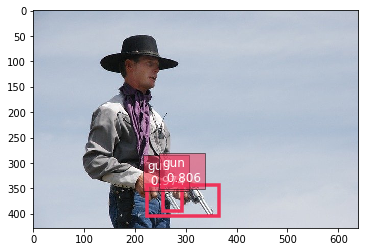

In [27]:
set_output_params(vis_thresh=0.8, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img13.jpg", mod);

gun
 0.9852204322814941 [210.43271484375, 46.960205078125, 449.666552734375, 297.9845703125]
['gun\n', 0.9852204322814941, [210.43271484375, 46.960205078125, 449.666552734375, 297.9845703125]]


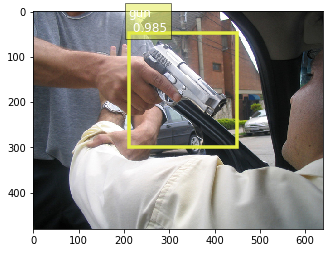

In [28]:
set_output_params(vis_thresh=0.4, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/weapons_test/img14.jpg", mod);